## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 409kB 2.8MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


/content/drive/My Drive/Colab Notebooks/bayesian-dl-experiments
datasets_files			 experiment_nn_capacity_1.ipynb  ronald_bdl
experiment_comparison_toy.ipynb  experiment_nn_capacity_2.ipynb  test_results
experiment_convergence_1.ipynb	 LICENSE
experiment_convergence_2.ipynb	 README.md


### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
NumPy Version: 1.17.4
PyTorch Version: 1.3.1
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

CUDA Version: 10.1.243
cuDNN Version: 7603
CUDA Device Name: Tesla K80
CUDA Capabilities: (3, 7)


### Toy dataset settings

In [0]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [0]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.5

# L2 regularization strength
reg_strength = 0.3

# Epochs
n_epochs = 400

# Optimizer learning rate
learning_rate = 0.01

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 1000

### Directory path to save results

In [0]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [0]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    dropout_rate=dropout_rate,
    dropout_type='bernoulli',
)

# Vanilla Variational Inference
uncertainty_methods['vi'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.001})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    if loss_function_type in ('test_ll_mc', 'rmse_mc'):
                        _, _, _, metrics = network.predict_dist(
                            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                        if loss_function_type == 'test_ll_mc':
                            total_loss = -(metrics[loss_function_type])
                    else:
                        total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNetMCDropout(
  (input): ModuleDict(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (relu): ReLU()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)

[iteration 0001] loss: 581.3885
[iteration 0101] loss: 573.1013
[iteration 0201] loss: 416.7278
[iteration 0301] loss: 355.6257
final loss = tensor(342.6555, device='cuda:0', grad_fn=<MseLossBackward>)
training time = 1.2635858058929443 seconds

Now running vi
FCNetPyro(
  (input): PyroModuleDict(
    (linear): PyroLinear(in_features=1, out_features=100, bias=True)
    (relu): PyroReLU()
  )
  (output): PyroLinear(in_features=100, out_features=1, bias=True)
  (guide): AutoDiagonalNormal()
)

[iteration 0001] loss: 201758.9384
[iteration 0101] loss: 265222.0857
[iteration 0201] loss: 193631.8719
[iteration 0301] loss: 175912.5329


Warmup:   0%|          | 0/20000 [00:00, ?it/s]

final loss = 146579.83055102825
training time = 2.9763712882995605 seconds

Now running hmc
FCNetPyro(
  (input): PyroModuleDict(
    (linear): PyroLinear(in_features=1, out_features=100, bias=True)
    (relu): PyroReLU()
  )
  (output): PyroLinear(in_features=100, out_features=1, bias=True)
  (guide): AutoDiagonalNormal()
)



Sample: 100%|██████████| 20000/20000 [19:17, 13.60it/s, step size=3.54e-01, acc. prob=0.988]


final loss = 146579.83055102825
training time = 1157.904168844223 seconds



## Plot the results

testing time = 0.35886192321777344 seconds

Mean = tensor([-20.9893, -19.6997, -19.5330, -19.0160, -18.5650, -17.0558, -17.0908,
        -16.6248, -15.8226, -15.0915, -14.8097, -13.7097, -13.4621, -12.6664,
        -12.9021, -11.9939, -11.0177, -10.8771,  -9.9844,  -9.1873,  -8.7411,
         -8.6770,  -7.6461,  -7.3782,  -6.4107,  -5.8852,  -5.5254,  -4.9850,
         -4.2077,  -3.7100,  -3.1396,  -2.7830,  -2.3067,  -1.9563,  -1.5861,
         -1.4079,  -1.0958,  -0.8732,  -0.6872,  -0.5065,  -0.3505,  -0.1969,
         -0.0499,   0.0466,   0.1476,   0.2106,   0.2335,   0.3225,   0.3590,
          0.4611,   0.4527,   0.5620,   0.6338,   0.7231,   0.8342,   0.8837,
          1.0369,   1.1911,   1.3568,   1.4128,   1.5497,   1.7450,   1.8904,
          1.9576,   2.2230,   2.2903,   2.5660,   2.6995,   2.9032,   3.3383,
          3.9568,   4.3910,   4.6649,   5.2600,   5.7300,   6.4290,   7.4250,
          8.0542,   8.8695,   9.5977,   9.6270,  11.1967,  11.0631,  11.8037,
         12.9

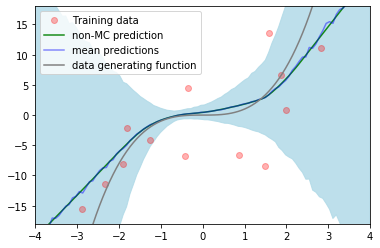

testing time = 1.1811308860778809 seconds

Mean = tensor([17.1965, 17.0566, 16.8627, 15.9849, 15.9715, 15.3784, 15.2794, 14.6221,
        14.5176, 14.1523, 13.8950, 13.6967, 13.1112, 12.9690, 12.5135, 12.2274,
        11.6590, 11.4189, 11.2427, 10.9720, 10.5526, 10.3179,  9.9542,  9.6798,
         9.5079,  8.9587,  8.7927,  8.5935,  8.3620,  8.1808,  7.8035,  7.4364,
         7.0538,  7.1752,  7.0609,  6.9255,  6.8984,  6.2705,  6.2891,  5.8705,
         4.8622,  4.6507,  3.6703,  3.0338,  2.2136,  1.5687,  0.8887,  0.5529,
         0.1252, -0.2508, -1.0104, -1.9286, -3.0580, -3.6190, -4.0725, -4.3726,
        -5.0923, -5.0208, -5.5188, -5.7470, -5.8311, -6.0343, -6.4986, -5.9835,
        -6.4270, -6.2726, -6.4520, -6.7575, -6.4752, -6.2655, -6.3676, -6.7018,
        -6.4564, -6.6592, -7.1846, -7.1263, -6.9241, -6.9128, -6.8024, -7.2843,
        -6.9877, -6.9740, -7.1937, -7.1173, -7.2194, -7.5266, -7.3462, -7.6124,
        -7.6995, -7.7966, -8.1664, -8.0226, -8.0621, -8.5072, -8.0549,

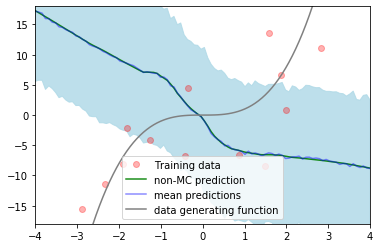

testing time = 1.0980234146118164 seconds

Mean = tensor([ 3.2617e+01,  3.2094e+01,  3.1203e+01,  3.0800e+01,  3.0071e+01,
         2.8996e+01,  2.8939e+01,  2.8188e+01,  2.7293e+01,  2.6814e+01,
         2.5835e+01,  2.5366e+01,  2.4596e+01,  2.4020e+01,  2.3478e+01,
         2.2767e+01,  2.2045e+01,  2.1520e+01,  2.0921e+01,  2.0004e+01,
         1.9382e+01,  1.8660e+01,  1.7944e+01,  1.7504e+01,  1.6864e+01,
         1.6227e+01,  1.5341e+01,  1.5235e+01,  1.3970e+01,  1.3912e+01,
         1.2971e+01,  1.2249e+01,  1.1828e+01,  1.1251e+01,  1.0594e+01,
         9.5161e+00,  8.7842e+00,  8.4289e+00,  7.4104e+00,  6.8321e+00,
         5.8310e+00,  5.1809e+00,  4.4906e+00,  3.9078e+00,  3.0620e+00,
         2.2628e+00,  1.8574e+00,  1.1575e+00, -1.4792e-03, -3.1313e-01,
        -2.7291e-01, -6.8002e-01, -4.9924e-01, -3.4178e-01,  3.3846e-01,
         5.3194e-01,  5.2382e-01,  1.1268e+00,  1.2389e+00,  1.7783e+00,
         2.2354e+00,  2.0337e+00,  2.5000e+00,  2.6498e+00,  2.8970e+00,
 

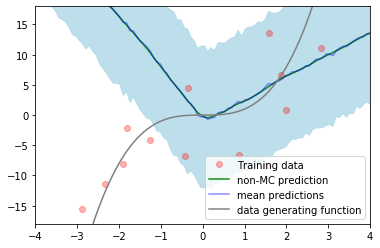

In [20]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc = network(X_test)

    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.9)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean predictions', alpha=0.45)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=1200)
    
    plt.show()